# 1st delete NaN

In [30]:
import numpy as np
import pandas as pd

In [31]:
train = pd.read_csv('data/train.csv')
predict = pd.read_csv('data/test.csv')

In [32]:
passenger_id = predict[['id']].copy()

In [33]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [34]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,750000.0,374999.500000,216506.495284,0.0,187499.75000,374999.50000,562499.25000,749999.00
Episode_Length_minutes,662907.0,64.504738,32.969603,0.0,35.73000,63.84000,94.07000,325.24
Host_Popularity_percentage,750000.0,59.859901,22.873098,1.3,39.41000,60.05000,79.53000,119.46
Guest_Popularity_percentage,603970.0,52.236449,28.451241,0.0,28.38000,53.58000,76.60000,119.91
Number_of_Ads,749999.0,1.348855,1.151130,0.0,0.00000,1.00000,2.00000,103.91
Listening_Time_minutes,750000.0,45.437406,27.138306,0.0,23.17835,43.37946,64.81158,119.97


In [35]:
predict.isnull().sum()

id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64

In [36]:
train.isnull().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [38]:
train.nunique()

id                             750000
Podcast_Name                       48
Episode_Title                     100
Episode_Length_minutes          12268
Genre                              10
Host_Popularity_percentage       8038
Publication_Day                     7
Publication_Time                    4
Guest_Popularity_percentage     10019
Number_of_Ads                      12
Episode_Sentiment                   3
Listening_Time_minutes          42807
dtype: int64

In [39]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


# Preprocessing of data

In [40]:
def create_features(df):
    df[['Episode_Name','Episode_Num']] = df['Episode_Title'].str.split(' ', expand=True)
    df['Episode_Num'] = df['Episode_Num'].astype(int)

    # ジャンルごとにホストの人気度の平均を計算して，それを辞書型に変換
    #genre_to_weight = df.groupby('Genre')['Host_Popularity_percentage'].mean().to_dict()
    #df['Host_Popularity_by_Genre'] =  df['Host_Popularity_percentage'] * df['Genre'].map(genre_to_weight)
    """
    # 広告数とホスト人気の関係    
    ads_to_weight = df.groupby('Number_of_Ads')['Host_Popularity_percentage'].mean().to_dict()
    df['Host_Popularity_by_Ads'] =  df['Host_Popularity_percentage'] * df['Number_of_Ads'].map(ads_to_weight)
    
    # 視聴時間の長さ / 広告数
    ads_to_weight = df.groupby('Number_of_Ads')['Episode_Length_minutes'].mean().to_dict()
    df['Episode_Ads'] =  df['Episode_Length_minutes'] / df['Number_of_Ads'].map(ads_to_weight)

    
    """
    # ホストの人気 ＊ エピソードの長さ
    #df['Host_Popularity_by_Episode_Length'] = df['Host_Popularity_percentage'] * df['Episode_Length_minutes']

    # ホスト人気 * ゲスト人気
    #df['Host_Guest_Popularity'] = df['Host_Popularity_percentage'] * df['Guest_Popularity_percentage']
    
    return df

train = create_features(train)
predict = create_features(predict)

In [41]:
train.nunique()

id                             750000
Podcast_Name                       48
Episode_Title                     100
Episode_Length_minutes          12268
Genre                              10
Host_Popularity_percentage       8038
Publication_Day                     7
Publication_Time                    4
Guest_Popularity_percentage     10019
Number_of_Ads                      12
Episode_Sentiment                   3
Listening_Time_minutes          42807
Episode_Name                        1
Episode_Num                       100
dtype: int64

In [42]:
# columns to drop 
def delete_columns(df):
    #df.drop(columns=['id','Episode_Title','Episode_Length_minutes','Guest_Popularity_percentage'], inplace=True)
    df.drop(columns=['id','Episode_Title','Episode_Name','Listening_Time_minutes'], inplace=True)
    return df

train = delete_columns(train)
predict = delete_columns(predict)

In [43]:
train.head()

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Episode_Num
0,Mystery Matters,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,98
1,Joke Junction,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,26
2,Study Sessions,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,16
3,Digital Digest,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,45
4,Mind & Body,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,86


# Data preparation before modeling

### Since there are few tpyes of object data,label encoding will be applied


In [44]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

def label_enocding(df,columns):
    le = LabelEncoder()

    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

encoding_cols = ['Podcast_Name','Genre','Publication_Day',
                 'Publication_Time','Episode_Sentiment']

train = label_enocding(train, encoding_cols)
predict = label_enocding(predict, encoding_cols)


In [45]:
train.head()

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Episode_Num
0,34,NaN,9,74.81,4,3,NaN,0.0,2,31.41998,98
1,24,119.80,1,66.95,2,0,75.95,2.0,0,88.01241,26
2,40,73.90,2,69.97,5,1,8.97,0.0,0,44.92531,16
3,10,67.17,8,57.22,1,2,78.70,2.0,2,46.27824,45
4,31,110.51,3,80.07,1,0,58.68,3.0,1,75.61031,86


In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 750000 non-null  int64  
 1   Episode_Length_minutes       662907 non-null  float64
 2   Genre                        750000 non-null  int64  
 3   Host_Popularity_percentage   750000 non-null  float64
 4   Publication_Day              750000 non-null  int64  
 5   Publication_Time             750000 non-null  int64  
 6   Guest_Popularity_percentage  603970 non-null  float64
 7   Number_of_Ads                749999 non-null  float64
 8   Episode_Sentiment            750000 non-null  int64  
 9   Listening_Time_minutes       750000 non-null  float64
 10  Episode_Num                  750000 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 62.9 MB


In [47]:
from sklearn.model_selection import train_test_split

def split_data(df, test_size=0.2, random_state=42):
    X = df.drop(columns=['Listening_Time_minutes'])
    y = df['Listening_Time_minutes']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(train)
predict_X = predict.copy()

# Model Construction

In [48]:
import xgboost as xgb

# XGBoostモデルの構築
def build_xgboost_model(n_estimators=100,max_depth=5,learning_rate=0.1):
    """XGBoostモデルを構築する関数"""
    model = xgb.XGBRegressor(
        # 回帰タスクに適した損失関数（MSE）
        objextive='reg:squarederror',
        # 決定木の数
        n_estimators=n_estimators,
        # 決定機の深さ
        max_depth=max_depth,
        # 学習率(小さいほど安定，収束が遅くなる)
        learning_rate=learning_rate,
        # 乱数シード
        random_state=42
    )
    return model

# XGBoostモデルの構築
xgb_X_train = X_train
xgb_X_test = X_test

# モデルの構築
xgb_model = build_xgboost_model()

/Users/yasuo/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:17:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "objextive" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


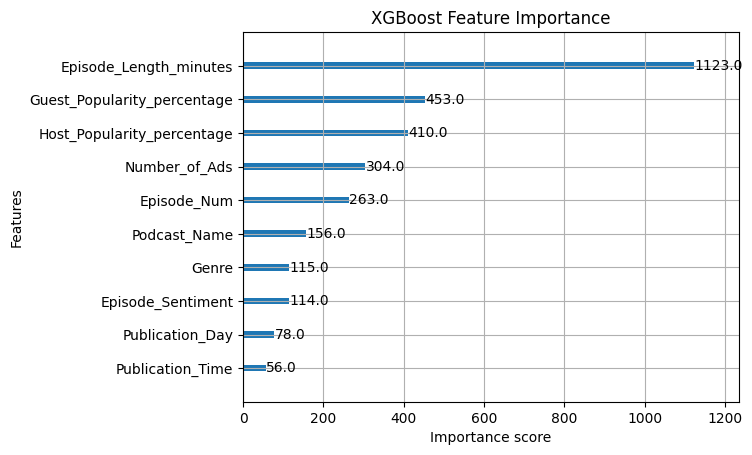

In [49]:
import matplotlib.pyplot as plt

# Train XGBoost model
xgb_model.fit(X_train, y_train) # XGBoostモデルの学習

# Feature importance
xgb.plot_importance(xgb_model) # 特徴量の重要度をプロット
plt.title('XGBoost Feature Importance') # タイトル
plt.show() # グラフの表示

# Model evalution

In [50]:
xgb_pred = xgb_model.predict(X_test)

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def evaluate_metrics(y_true,y_pred):
    
    results = []

    def calulate_metrics(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        return {
            'MSE': mse,
            'RMSE': mae,
            'R2': r2
        }
    results.append(calulate_metrics(y_true, y_pred))

    return pd.DataFrame(results)

results = evaluate_metrics(y_test, xgb_pred)
display(results)

,MSE,RMSE,R2
0,170.740295,9.512983,0.767961


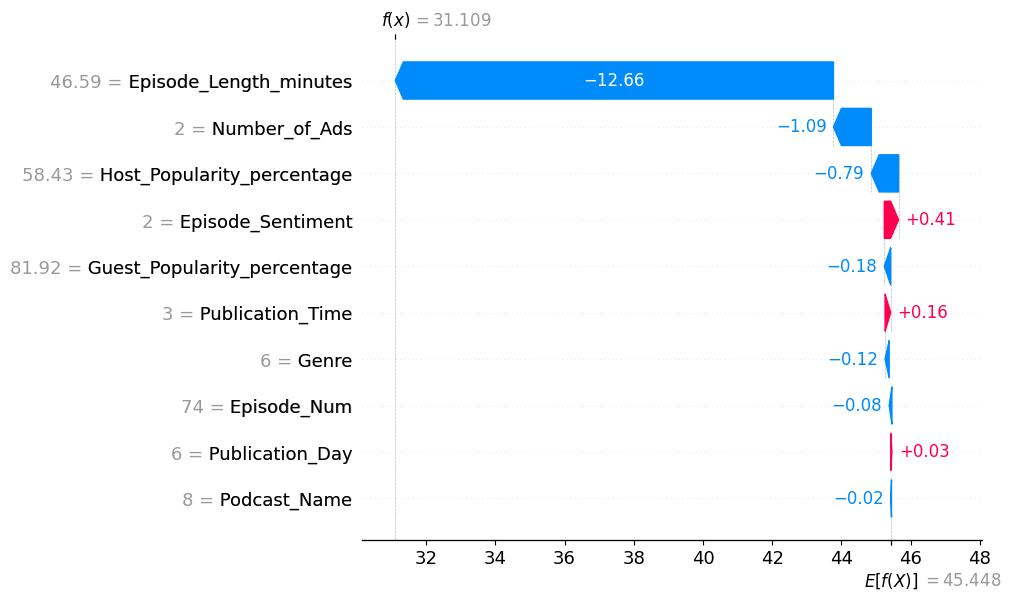

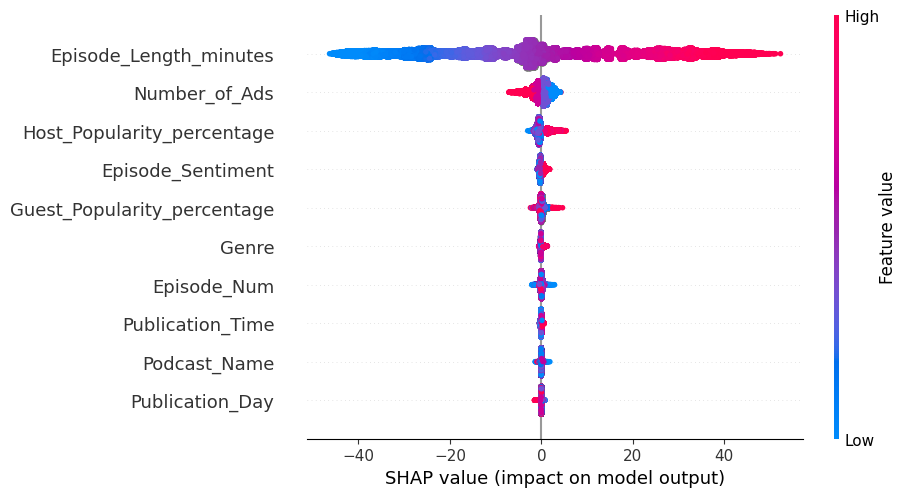

In [52]:
import shap

def explain_model(model):
    # SHAP explainerを作成（TreeExplainerはXGBoostなどに最適）
    explainer = shap.Explainer(model)

    # SHAP値を計算（X_testに対して）
    shap_values = explainer(X_test)

    # 可視化（例：1件目の予測理由）
    shap.plots.waterfall(shap_values[0])

    # 全体の特徴量の影響（要約プロット）
    shap.plots.beeswarm(shap_values)

explain_model(xgb_model)


# Optuna

In [53]:
import optuna
def optimize_xgboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500), # 決定木の数
        'max_depth': trial.suggest_int('max_depth', 3, 10), # 決定木の深さ
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3), # 学習率
        'subsample': trial.suggest_float('subsample', 0.6, 1.0), # サブサンプル
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), # 列のサブサンプル
        'gamma': trial.suggest_float('gamma', 0, 1), # 葉ノードを分割するために必要な最小損失削減
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), # 葉ノードの重みの最小合計
        'objective': 'reg:squarederror', # 回帰タスクに適した損失関数
        'random_state': 42                
    }

    model = xgb.XGBRegressor(**params)
    model = model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

study = optuna.create_study(direction='minimize')
study.optimize(optimize_xgboost, n_trials=50)

# dislay best results
print('Best trial:')
trial = study.best_trial # 最良のトライアル
print(f"  MSE: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Predict
optimized_xgb = xgb.XGBRegressor(**trial.params, random_state=42)
optimized_xgb.fit(X_train, y_train)

[I 2025-04-16 21:17:18,607] A new study created in memory with name: no-name-1d726c8c-9c21-4935-815d-afe34b4dc216
[I 2025-04-16 21:17:23,569] Trial 0 finished with value: 169.36032995718108 and parameters: {'n_estimators': 457, 'max_depth': 7, 'learning_rate': 0.0184863379327076, 'subsample': 0.6941523923142704, 'colsample_bytree': 0.9730206952373884, 'gamma': 0.7363472167346664, 'min_child_weight': 5}. Best is trial 0 with value: 169.36032995718108.
[I 2025-04-16 21:17:25,586] Trial 1 finished with value: 167.75884812647254 and parameters: {'n_estimators': 192, 'max_depth': 8, 'learning_rate': 0.23325182249713566, 'subsample': 0.8616662046818211, 'colsample_bytree': 0.9935261801709148, 'gamma': 0.20461492259422676, 'min_child_weight': 5}. Best is trial 1 with value: 167.75884812647254.
[I 2025-04-16 21:17:27,210] Trial 2 finished with value: 168.97586199053023 and parameters: {'n_estimators': 189, 'max_depth': 6, 'learning_rate': 0.16049368185284396, 'subsample': 0.6330063836574243, '

Best trial:
  MSE: 163.4232847009613
  Params: 
    n_estimators: 388
    max_depth: 10
    learning_rate: 0.06899502681410158
    subsample: 0.9801509955873268
    colsample_bytree: 0.8417385418657513
    gamma: 0.6543179571534401
    min_child_weight: 3


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8417385418657513, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.6543179571534401, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06899502681410158,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=388, n_jobs=None,
             num_parallel_tree=None, ...)

In [54]:
optimized_pred = optimized_xgb.predict(xgb_X_test)
optimized_metrics = evaluate_metrics(y_test,  optimized_pred) # 評価
display(optimized_metrics)

,MSE,RMSE,R2
0,163.423285,9.246299,0.777905


In [55]:
# 保存（バイナリ形式）
#optimized_xgb.save_model("model/xgboost/xgb_model.json")  # .json でも .model でもOK

"""
import xgboost as xgb

# モデルの読み込み
loaded_model = xgb.XGBRegressor()
loaded_model.load_model("xgb_model.json")
"""

'\nimport xgboost as xgb\n\n# モデルの読み込み\nloaded_model = xgb.XGBRegressor()\nloaded_model.load_model("xgb_model.json")\n'

In [56]:
predixt_y = optimized_xgb.predict(predict_X)

predict_df = pd.DataFrame(predixt_y , columns=['Listening_Time_minutes'])

submission = pd.concat([passenger_id, predict_df], axis=1)

display(submission.head())

,id,Listening_Time_minutes
0,750000,54.227524
1,750001,18.531912
2,750002,48.442448
3,750003,72.331497
4,750004,46.406757


In [57]:
#submission.to_csv('submit/xgb_submit/submission4.csv', index=False)